# Nutrient analysis of global fisheries II

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import theano.tensor as tt
from pymc3.backends import SQLite
import seaborn as sns
import scipy as sp
import pdb

In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

## Import data

In [3]:
# Nutritional data
ndata = pd.read_excel('Nutrient_data.xlsx')
# Traits data
tdata = pd.read_excel('Traits_all.xlsx')

In [4]:
# Add traits information to nutritional dataframe
indx = match(ndata.Species_from_search.unique(),list(tdata.species_traits_all.values))
rindx = match(ndata.Species_from_search,list(ndata.Species_from_search.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus_1', 'DemersPelag',
       'EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm']
# Port over
for trait in tmp:
    ndata[trait] = tdata[trait].values[indx][rindx]

ndata.head()

,ID_no,Species_from_search,Protein_Replicates,Protein_Value_perc,Protein_Variance,Zn_Replicates,Zn_Value,Zn_Variance,Ca_Replicates,Ca_Value,...,Genus_1,DemersPelag,EnvTemp,DepthRangeDeep,trophic_level,Feeding_path,LMax,BodyShapeI,K,tm
0,A_3,Merluccius_merluccius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Merluccius,demersal,temperate,1075.0,4.40,pelagic,140.0,elongate,0.148,4.199469
1,A_4,Scomber_scombrus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
2,A_38,Scomber_scombrus,NaN,NaN,NaN,11,0.8090,NaN,NaN,NaN,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
3,A_39,Merluccius_gayi_gayi,NaN,NaN,NaN,11,0.1787,NaN,NaN,NaN,...,Merluccius,pelagic_oceanic,polar_deep,500.0,4.26,pelagic,87.0,fusiform,0.120,5.100000
4,A_40,Engraulis_encrasicolus,NaN,NaN,NaN,11,0.7041,NaN,NaN,NaN,...,Engraulis,pelagic_neritic,subtropical,400.0,3.12,pelagic,20.0,elongate,1.000,1.000000


In [5]:
ndata.columns.values

array(['ID_no', 'Species_from_search', 'Protein_Replicates',
       'Protein_Value_perc', 'Protein_Variance', 'Zn_Replicates',
       'Zn_Value', 'Zn_Variance', 'Ca_Replicates', 'Ca_Value',
       'Ca_Variance', 'Fe_Replicates', 'Fe_Value', 'Fe_Variance',
       'Se_Replicates', 'Se_Value', 'Se_Variance', 'P_Replicates',
       'P_Value', 'P_Variance', 'Mg_Replicates', 'Mg_Value',
       'Mg_Variance', 'VitA_Replicates', 'VitA_Value', 'VitA_Variance',
       'VitB12_Replicates', 'VitB12_Value', 'VitB12_Variance',
       'O3_Replicates', 'O3_Value', 'O3_Variance', 'Unnamed: 32',
       'Form_Clean', 'Search', 'Year', 'GeographicLocation_Cleaned',
       'Family', 'Prep', 'Protein_prep', 'Minerals_prep', 'Vitamin_prep',
       'FA_prep', 'Protein_Sample_Weight', 'Zn_Sample_Weight',
       'Ca_Sample_Weight', 'Fe_Sample_Weight', 'Se_Sample_Weight',
       'P_Sample_Weight', 'Mg_Sample_Weight', 'VitA_Sample_Weight',
       'VitB12_Sample_Weight', 'O3_Sample_Weight', 'Class', 'Order',
     

### Datasets

In [6]:
Nutrients = ['Protein', 'Zinc', 'Iron', 'Calcium', 'Omega-3', 'Vitamin_A', 'Selenium']
Nkeys = ['Protein_Value_perc', 'Zn_Value', 'Fe_Value', 'Ca_Value', 'O3_Value', 'VitA_Value', 'Se_Value']
nnutrients = len(Nutrients)

In [7]:
# Sample sizes for each nutrient
[sum(np.isnan(ndata[n].values)==False) for n in Nkeys]

[627, 196, 173, 170, 176, 69, 134]

## ======= Change nutrient here & likelihood in the model ========= #

In [8]:
i = 0
nut = Nutrients[i]
nut

'Protein'

In [9]:

# Response
var = Nkeys[i]
Y_ = ndata[var].values


In [10]:
len(Y_)

932

In [11]:
# Units
#'Protein' - g/100g OK
#'Zinc' - mg/100g ---> multiply by 10
#'Iron' - mg/100g ---> multiply by 10
#'Calcium' - mg/100g OK
#'Omega-3': - g/100g ----> multiply by 10
#'Vitamin_A' - μg/100g OK
#'Selenium' - μg/100g OK


# Response
var = Nkeys[i]
Y_ = ndata[var].values

# NA Filter
indx = np.isfinite(Y_)
### ZEROS Filter
if nut in ['Selenium']:
    indx = indx*(Y_>0)
### ZEROS Filter
if nut in ['Protein']:
    indx = indx*(Y_<60)

# Remove non-useful data
Y_ = Y_[indx]

# Unit conversions for better models
if nut in ['Zinc','Iron','Omega-3']:
    Y_ = Y_*10

# Log-scale
Ylog = np.log(Y_+1)

# Observation scale
Y = Y_
# Filter dataframe
tmpdata = ndata[indx]

# Index for orders
Order,Io = indexall(tmpdata.Order.values)
nord = len(Order)

# Covariates
Habitat,Ih = indexall_B(tmpdata['DemersPelag'].values, 'demersal')
nhabs = len(Habitat)
Climate,Ic = indexall_B(tmpdata['EnvTemp'].values, 'temperate')
nclim = len(Climate)
MaxDepth = np.log(tmpdata['DepthRangeDeep'].values)
TL = tmpdata['trophic_level'].values
Pelagic = tmpdata['Feeding_path'].values=="pelagic"
LMax = np.log(tmpdata['LMax'].values)
Body,Ib = indexall_B(tmpdata['BodyShapeI'].values, 'fusiform')
nbod = len(Body)
K = tmpdata['K'].values
tm = np.log(tmpdata['tm'].values)

# Nussiance parameters
Form,If = indexall_B(tmpdata['Form_Clean'].values, 'muscle')
nform = len(Form)
Prep,Ip = indexall_B(tmpdata['Prep'].values, 'wet')
nprep = len(Prep)
Search,Is = indexall_B(tmpdata['Search'].values, 'WOS')
nsearch = len(Search)
Geog,Ig = indexall(tmpdata['GeographicLocation_Cleaned'].values)
ngeo = len(Geog)

In [12]:
Body

['fusiform', 'short_deep', 'elongate', 'flat']

In [13]:
Habitat

['demersal',
 'reef_associated',
 'benthopelagic',
 'pelagic_neritic',
 'pelagic_oceanic']

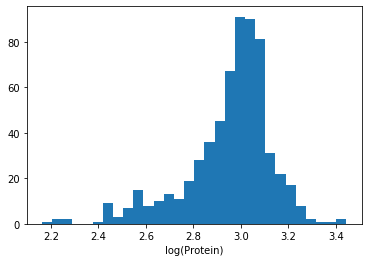

In [14]:
plt.hist(Ylog,bins=30)
plt.xlabel('log('+nut+')');

## Specify Bayesian model

In [15]:
Model_1 = pm.Model()

with Model_1:
    # Intercept
    γ0 = pm.Normal('Intercept', mu=0, tau=0.0001)
    # Observation model
    #σγ = pm.Uniform('Sigma_γ', 0, 100)
    #β0 = pm.Normal('Order', mu=γ0, sd=σγ, shape=nord)
    #pi_tilde = pm.Normal('pi_t', 0, 1, shape=nord)
    #β0 = pm.Deterministic('Order', γ0 + σγ*pi_tilde)
    # Random effect of data-source
    #β01 = pm.Normal('Geography', 0, 1, shape=ngeo)   
    
    #"""
    # Habitat type
    β1_ = pm.Normal('Habitat', 0, tau=0.01, shape=nhabs-1)
    β1 = tt.set_subtensor(tt.zeros(shape=nhabs)[1:], β1_)
    # Climate
    β2_ = pm.Normal('Climate', 0, tau=0.01, shape=nclim-1)
    β2 = tt.set_subtensor(tt.zeros(shape=nclim)[1:], β2_)
    # Maximum Depth
    β3 = pm.Normal('MaxDepth', 0, tau=0.01)
    # Total Length
    β4 = pm.Normal('TL', 0, tau=0.01)
    # Pelagic/demersal
    β5 = pm.Normal('pelagic', 0, tau=0.01)
    # Maximum length
    β6 = pm.Normal('LMax', 0, tau=0.01)
    # Body form
    β7_ = pm.Normal('Body', 0, tau=0.01, shape=nbod-1)
    β7 = tt.set_subtensor(tt.zeros(shape=nbod)[1:], β7_)
    # Growth parameter
    β8 = pm.Normal('K', 0, tau=0.01)
    # Age at maturity
    β9 = pm.Normal('tm', 0, tau=0.01)
    
    # Form of sample
    β10_ = pm.Normal('Form', 0, tau=0.01, shape=nform-1)
    β10 = tt.set_subtensor(tt.zeros(shape=nform)[1:], β10_)
    # Form of prepartion
    β11_ = pm.Normal('Prep', 0, tau=0.01, shape=nprep-1)
    β11 = tt.set_subtensor(tt.zeros(shape=nprep)[1:], β11_)
    # Database used
    β12_ = pm.Normal('Search', 0, tau=0.01, shape=nsearch-1)
    β12 = tt.set_subtensor(tt.zeros(shape=nsearch)[1:], β12_)
    
    #"""
    
    # Mean model
    μ_ = γ0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    
    # Normal - log-Protein (0)
    μ = μ_
    σ = pm.Uniform('Sigma', lower=0, upper=1000)
    Yi = pm.Normal('Yi', mu=μ, sd=σ, observed=Ylog)
    
    # ST -  
    #μ = μ_
    #ν = pm.Uniform('nu', lower=0, upper=10)
    #σ = pm.Uniform('Sigma', lower=0, upper=1000)
    #Yi = pm.StudentT('Yi', nu=ν, mu=μ, sd=σ, observed=Ylog)
    
    # Gamma model - 
    #μ = tt.exp(μ_)
    #α = pm.Uniform('α', lower=0., upper=100.)
    #Yi = pm.Gamma('Yi', alpha=α, beta=α/μ, observed=Ylog)
    

In [16]:
# Sampling
with Model_1:
    # Draw samples
    trace = pm.sample(5000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, Search, Prep, Form, tm, K, Body, LMax, pelagic, TL, MaxDepth, Climate, Habitat, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [02:13<00:00, 165.20draws/s]
The acceptance probability does not match the target. It is 0.8917636772541204, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8970022702529016, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8939583392855395, but should be close to 0.8. Try to increase the number of tuning steps.


## Divergence analysis

In [17]:
def pairplot_divergence(trace, basevar, targetvar, ax=None, divergence=True, color='C3', divergence_color='C2'):
    #theta = trace.get_values(varname=basevar, combine=True)[:, 0]
    theta = trace.get_values(varname=basevar, combine=True)
    logtau = trace.get_values(varname=targetvar, combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(theta, logtau, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(theta[divergent], logtau[divergent], 'o', color=divergence_color)
    ax.set_xlabel(basevar)
    ax.set_ylabel(targetvar)
    ax.set_title('scatter plot between log('+targetvar+') and '+basevar);
    return ax

In [18]:
# A small wrapper function for displaying the MCMC sampler diagnostics as above
def report_trace(trace,basevar,targetvar,logscale=False):
    # plot the trace of log(tau)
    pm.traceplot({targetvar: trace.get_values(varname=targetvar, combine=False)});

    # plot the estimate for the mean of log(τ) cumulating mean
    if logscale:
        logtau = np.log(trace[targetvar])
    else:
        logtau = trace[targetvar]
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(15, 4))
    #plt.axhline(0.7657852, lw=2.5, color='gray')
    plt.plot(mlogtau, lw=2.5)
    plt.ylim(0, 2)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log('+targetvar+')')
    plt.title('MCMC estimation of log('+targetvar+')')
    plt.show()

    # display the total number and percentage of divergent
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size / len(trace) * 100
    print('Percentage of Divergent %.1f' % divperc)

    # scatter plot between log(tau) and theta[0]
    # for the identifcation of the problematic neighborhoods in parameter space
    pairplot_divergence(trace,basevar,targetvar);

In [19]:
#report_trace(trace,'Intercept','Sigma_γ')

## Summary plots

In [20]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,2.910,0.062,2.792,3.023,0.000,0.0,16515.0,16494.0,16509.0,14865.0,1.0
Habitat[0],0.004,0.022,-0.037,0.047,0.000,0.0,23071.0,12054.0,23084.0,16035.0,1.0
Habitat[1],-0.055,0.018,-0.087,-0.019,0.000,0.0,21301.0,19909.0,21282.0,16083.0,1.0
Habitat[2],-0.027,0.020,-0.064,0.012,0.000,0.0,17483.0,16055.0,17485.0,16103.0,1.0
Habitat[3],0.031,0.023,-0.011,0.075,0.000,0.0,18978.0,17301.0,18960.0,16844.0,1.0
Climate[0],0.037,0.016,0.007,0.067,0.000,0.0,17172.0,16820.0,17174.0,15806.0,1.0
Climate[1],-0.060,0.023,-0.105,-0.016,0.000,0.0,18792.0,18132.0,18787.0,15937.0,1.0
Climate[2],-0.078,0.024,-0.123,-0.030,0.000,0.0,17282.0,17154.0,17285.0,15554.0,1.0
MaxDepth,-0.016,0.006,-0.027,-0.005,0.000,0.0,25025.0,22836.0,25003.0,14596.0,1.0
TL,0.036,0.014,0.010,0.062,0.000,0.0,24245.0,22888.0,24246.0,15175.0,1.0


<Figure size 1224x792 with 0 Axes>

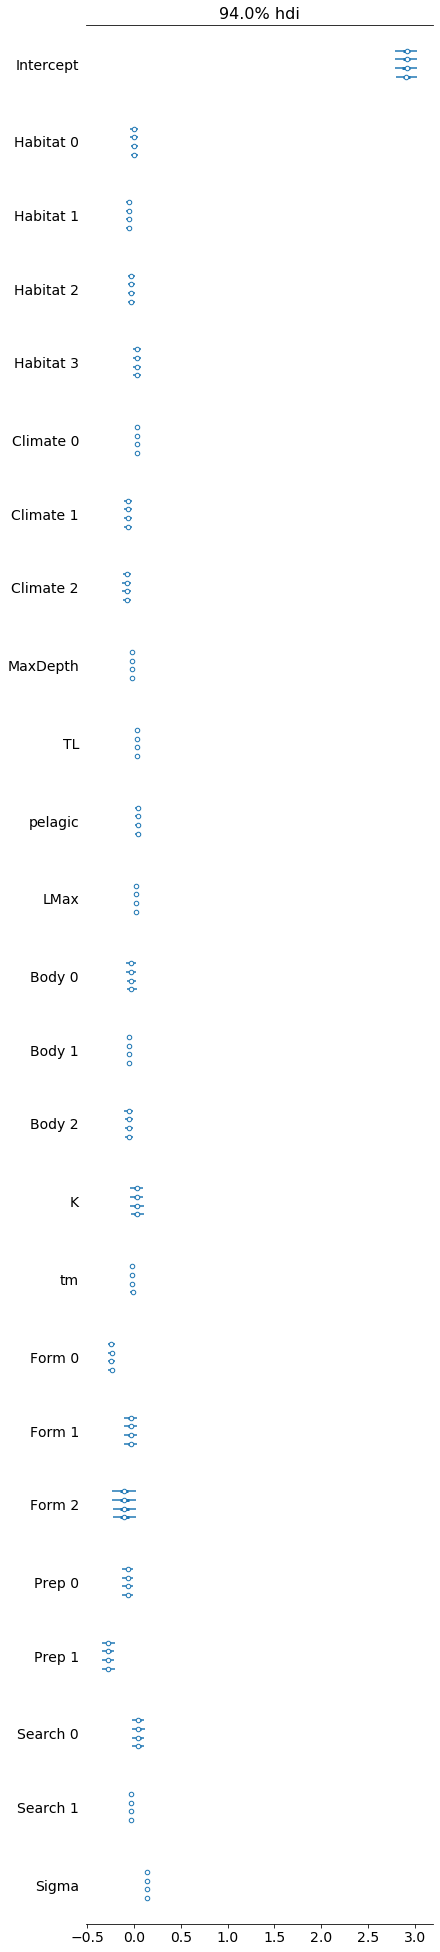

In [21]:
plt.figure(figsize=(17, 11))
pm.forestplot(trace)
plt.savefig('Figure_S3_'+nut+'.jpg',dpi=300);

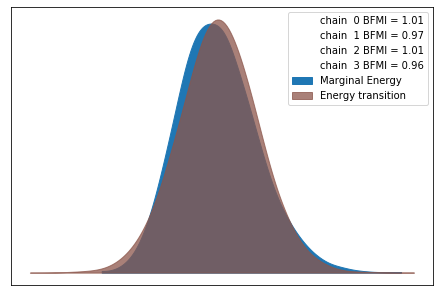

In [22]:
pm.plots.energyplot(trace);

In [23]:
pm.stats.waic(trace, Model_1)

/opt/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1411: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 20000 by 623 log-likelihood matrix

          Estimate       SE
elpd_waic   325.68    28.77
p_waic       30.40        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [24]:
# Export results 
out = pm.backends.tracetab.trace_to_dataframe(trace)
colnames = np.array(list(out.columns), dtype=object)
# Rename columns
colnames[match(grep('Habitat',list(colnames)),list(colnames))] = Habitat[1:]
colnames[match(grep('Climate',list(colnames)),list(colnames))] = Climate[1:]
colnames[match(grep('Body',list(colnames)),list(colnames))] = Body[1:]
colnames[match(grep('Form',list(colnames)),list(colnames))] = Form[1:]
colnames[match(grep('Prep',list(colnames)),list(colnames))] = Prep[1:]
colnames[match(grep('Search',list(colnames)),list(colnames))] = Search[1:]
# Rename
out.columns = list(colnames)

In [25]:
# Add baseline columns to dataframe
out['demersal'] = 0
out['temperate'] = 0
out['fusiform'] = 0
out['muscle'] = 0
out['wet'] = 0
out['WOS'] = 0

In [35]:
out.to_csv(nut+'_results.csv')

In [27]:
out.head()

,Intercept,reef_associated,benthopelagic,pelagic_neritic,pelagic_oceanic,subtropical,polar_deep,tropical,MaxDepth,TL,...,dry,Expert,FAO,Sigma,demersal,temperate,fusiform,muscle,wet,WOS
0,2.891036,0.026574,-0.051687,-0.041083,0.003734,0.071474,-0.012393,-0.059493,-0.013256,0.042925,...,-0.279306,0.051255,-0.047283,0.138922,0,0,0,0,0,0
1,2.886661,-0.018158,-0.079231,-0.033334,0.045598,0.028105,-0.104025,-0.076804,-0.024009,0.032128,...,-0.255107,0.035831,-0.037054,0.141776,0,0,0,0,0,0
2,2.964360,0.040147,-0.048911,-0.034814,0.024561,0.021673,-0.046269,-0.132635,-0.011821,0.036524,...,-0.287440,0.046254,-0.000671,0.137867,0,0,0,0,0,0
3,2.987290,0.022178,-0.038687,0.019086,0.039805,0.023601,-0.071105,-0.091082,-0.023683,0.056437,...,-0.238395,0.033118,-0.031649,0.137400,0,0,0,0,0,0
4,2.884838,-0.010495,-0.044736,-0.046235,0.038643,0.045589,-0.049904,-0.072351,-0.012894,0.015967,...,-0.305462,0.034040,-0.013691,0.142959,0,0,0,0,0,0


### Model-checking

In [28]:
ppc = pm.sample_ppc(trace, model=Model_1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 20000/20000 [00:30<00:00, 659.59it/s]


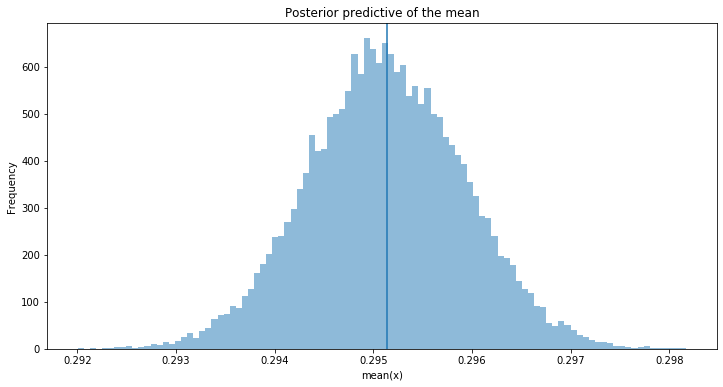

In [29]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean()/10 for n in ppc['Yi']], bins=100, alpha=0.5)
ax.axvline(Ylog.mean()/10)
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency')
plt.savefig('Figure_S4_'+nut+'.jpg',dpi=300);

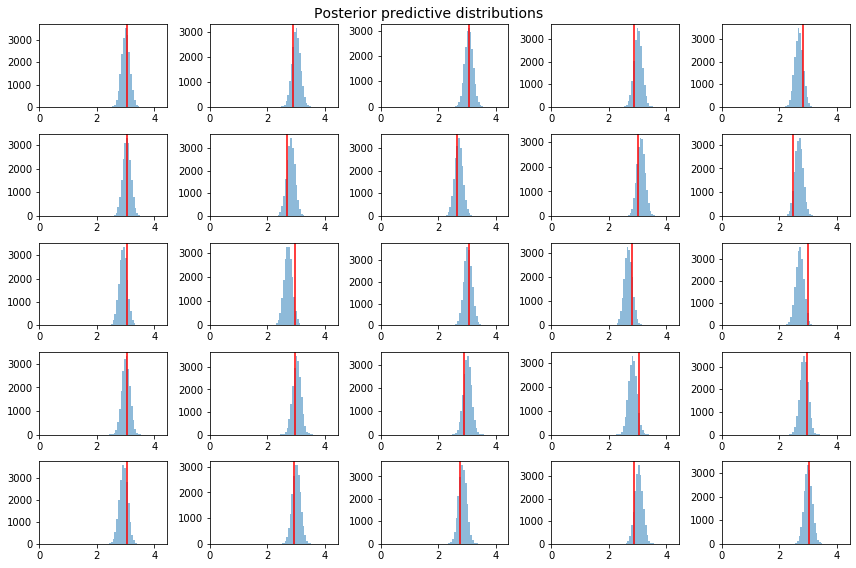

In [30]:
# Setup multipanel figure
nrows, ncols = 5, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))
ax_ = axes.flatten()

# Transform ppc
PPC = ppc['Yi'].T
# Index random observations
indx = np.random.randint(0,len(PPC),size=nrows*ncols)

# Iterate over random samples from ppc
for i in range(nrows*ncols):
    ax1 = ax_[i]
    ax1.hist(PPC[indx[i]], bins=19, alpha=0.5)
    ax1.axvline(Ylog[indx[i]],c='red')
    ax1.set_xlim(0,max(Ylog)+1)

fig.tight_layout()
fig.suptitle('Posterior predictive distributions', fontsize=14)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure_S5_'+nut+'.jpg',dpi=300);

In [31]:
def abline(intercept, slope):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',c='grey')

In [32]:
Io

array([ 0,  0,  0,  0,  0,  0,  1,  2,  2,  3,  4,  5,  5,  5,  5,  5,  5,
        6,  7,  7,  3,  3,  3,  3,  3,  3,  3,  3,  3,  8,  8,  9,  9,  9,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  9,
       10, 10, 11, 11, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13,  2,  2,  2,  2,  2,  2,  2,  2, 13,  3,  2, 13,  9, 14,  2,  2,
       14,  2,  2,  9, 15,  2,  2,  2, 16, 14, 16,  2, 14, 14,  2, 14, 16,
       15,  2,  2,  2,  2,  2,  2,  2,  2,  5, 11,  2,  2,  2, 15,  3,  9,
        9,  9,  9, 10, 10, 10, 10,  3, 17,  2, 18,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2, 19, 19, 19, 20, 13,  3,  3,  3, 21,
       11, 14, 17,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        3, 10, 10, 10,  7,  7,  7,  2,  2, 21,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2, 12, 12, 12,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2, 10, 10, 10, 10,  2,  2,  3,  3,  3,  3, 22,  2,  3,  3, 10,
       23, 10, 10,  2,  2

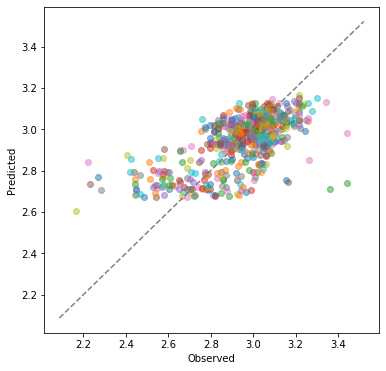

In [33]:
plt.subplots(figsize=(6, 6))
nobs = len(Ylog)
#ocol = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

# Iterate over random samples from ppc
for i in range(nobs):
    plt.scatter(Ylog[i], np.median(PPC[i]), alpha=0.5)

plt.xlabel('Observed')
plt.ylabel('Predicted')

abline(0,1)
    
fig.tight_layout()
plt.savefig('Figure_S6_'+nut+'.jpg',dpi=300);

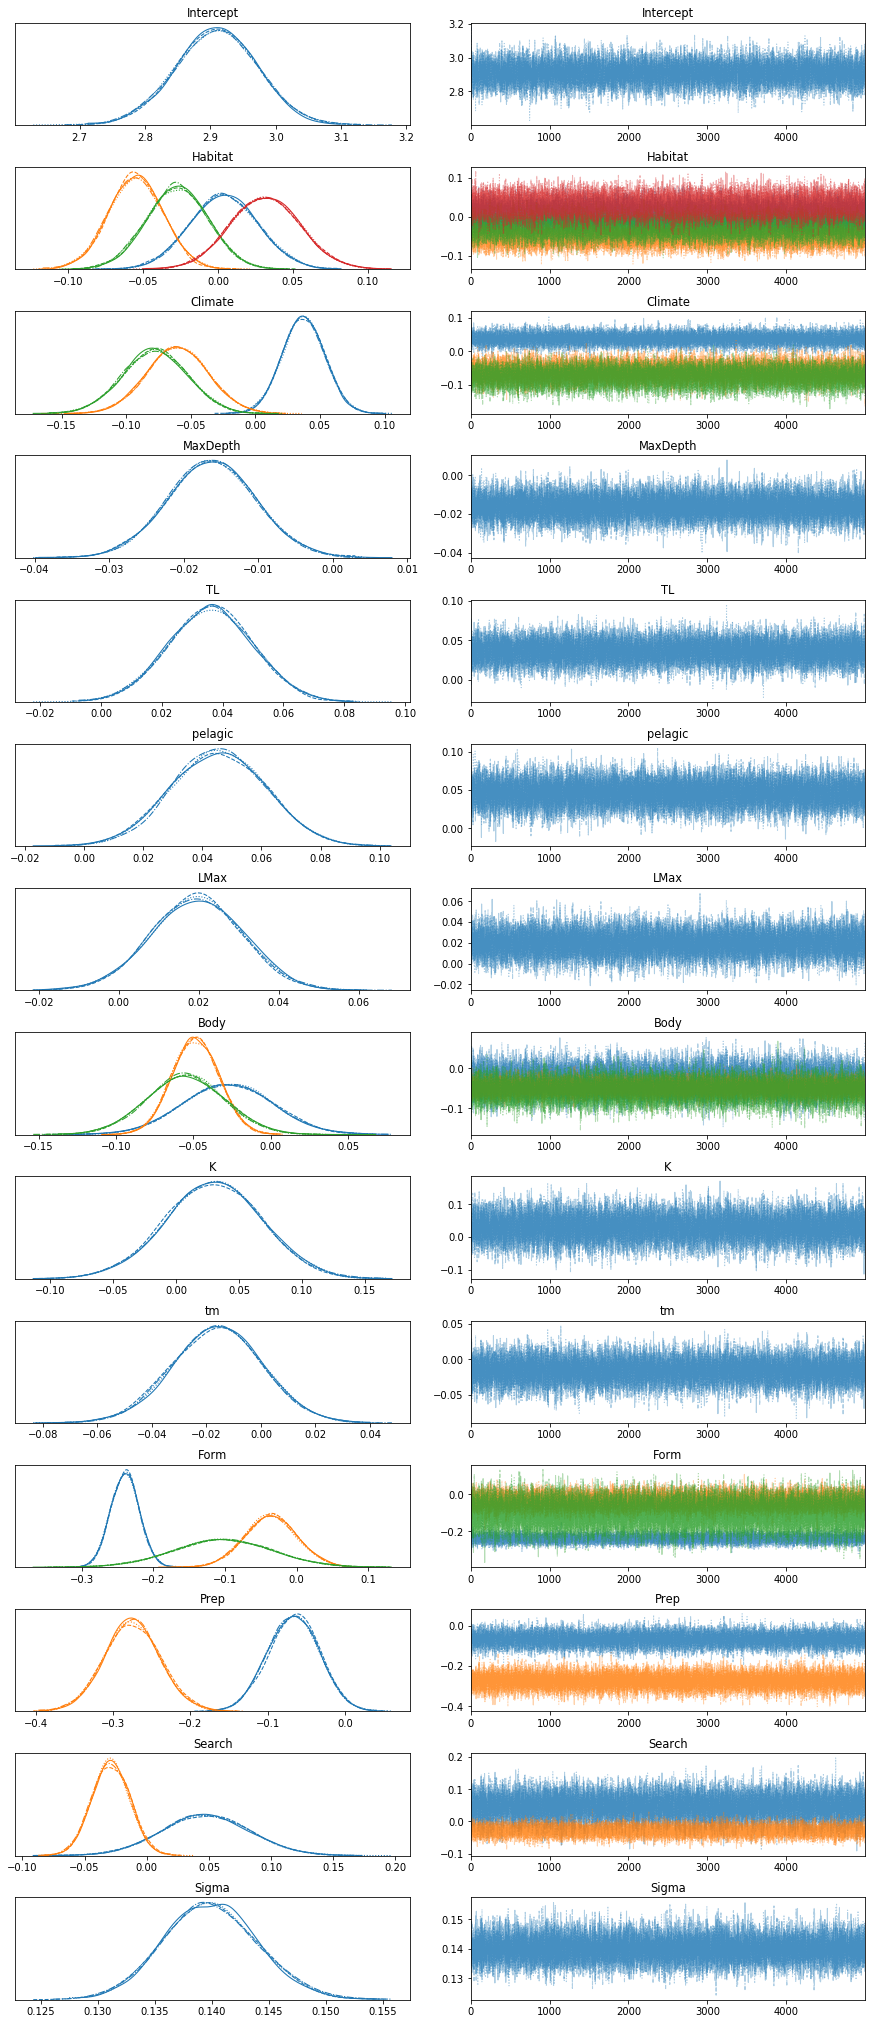

In [34]:
pm.traceplot(trace)
plt.savefig('Figure_S2_'+nut+'.jpg',dpi=300);